## Variational Genertion of Thermofield Double States

In [76]:
# Importing all of the necessary dependencies

import cirq
import random
import numpy as np
import math
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import scipy

The goal of this Notebook is to outline a the variational process outlined [this paper]('https://arxiv.org/abs/1906.02699') in order to generate Thermofield Double States (TFD states), which are defined as follows:

<br>
$$|TFD\rangle \ = \ \frac{1}{\sqrt{Z(\beta)}} \displaystyle\sum_{n} e^{- \beta E_n / 2} |E_n\rangle_A \otimes |E_n'\rangle_B$$
<br>

Notice how we are concered with the tensor product of two states for each term in the sum (we are concerned with two different systems of qubits, register $A$ and register $B$). We also define $H_A$ to be the Hamiltonian governing the dynamics of the qubits in the first register, with $H_A |E_n\rangle_A \ = \ E_n |E_n\rangle_A$, thus making our TFD state depend on both the energy eigenstates and the energy eigenvalues. It is also important to note that $\beta$ is defined as the inverse temperature of the system that we are describing, $\beta \ = \ 1/T$. $Z(\beta)$ denotes the partition function, which is given by:

<br>
$$Z(\beta) \ = \ \displaystyle\sum_{n} e^{- \beta E_n}$$
<br>

Finally, we define $E_n'\rangle_B$ to be a vector in the state space described by the second qubit register, $B$, specifically, the time-reversed counterpart of $|E_n\rangle_A$:

<br>
$$E_n'\rangle_B \ = \ \Theta |E_n\rangle_A \ = \ e^{i H_A t / \hbar} |E_n\rangle_A$$
<br>

**Part 2: Application**

We can begin by defining all of the necessary variables to run our simualtion, including the value of $\beta$, the transverse field strength, and the depth of the QAOA circuit. We will also use this block of code to intialize our two qubit registers, $A$ and $B$:

In [219]:
# Note: Beta is defined as inverse temperature, B = 1/T 

beta = 10 
transverse_field_strength = 2
testing_trials = 100
qubit_number = 2
depth = 1

# Initializing the qubits

qubits_a = []
qubits_b = []

for i in range(0, qubit_number):

    qubits_a.append(cirq.GridQubit(1, i))
    qubits_b.append(cirq.GridQubit(2, i))

Next, we can create a function that allows us to compute the matrix representation of the given Pauli-X Hamiltonian:

In [220]:
# Calculates the cost Hamiltonian matrix for the Ising model

def calculate_x_matrix(qubit_number, transverse_field_strength):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    # Creates the transverse field component of the matrix

    total_matrix = np.zeros((2**qubit_number, 2**qubit_number))

    for i in range(0, qubit_number):
        matrix = 1
        for k in range(0, qubit_number):
            if (k == i):
                matrix = np.kron(matrix, pauli_x)
            else:
                matrix = np.kron(matrix, identity)
        total_matrix = np.add(total_matrix, matrix)

    return total_matrix

print(calculate_x_matrix(4, 1))

[[0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]]


Next, we will calculate the eignevalues and eigenvectors of the cost Hamiltonian, which we will eventually use to test our variational algorithm.

In [221]:
# Calculating the eigenvalues and eigenvectors of the cost Hamiltonian

def find_eigenvec_eigenval(matrix):

    value, vector = np.linalg.eig(matrix)

    new_vector = []
    for v in range(0, len(vector)):
        holder = []
        for h in range(0, len(vector)):
            holder.append(vector[h][v])
        new_vector.append(holder)

    return [value, np.array(new_vector)]

Next, we want to create the layer in our QAOA-inspired circuit that evolves the first qubit register according to the target Hamiltonian:

In [222]:
# Defining the cost unitary

def create_cost_ham(qubits_x, qubit_number, parameter_list):

    # We'll start by experimenting with a simple X-model

    for i in range(0, qubit_number):
        yield cirq.Rx(-2*parameter_list[0]).on(qubits_x[i])

# Defining the time-reversed  cost unitary

def time_reversed_cost(qubits_x, qubit_number, parameter_list):

    # We'll start by experimenting with a simple X-model

    for i in range(0, qubit_number):
        yield cirq.Y.on(qubits_x[i])
        yield cirq.Rx(-2*parameter_list[0]).on(qubits_x[i])
        yield cirq.Y.on(qubits_x[i])

In [223]:
# Preaparing the partition function and each of the probability amplitudes of the diifferent terms in the TFD state

def calculate_terms_partition(eigenvalues):

    list_terms = []
    partition_sum = 0
    for i in eigenvalues:
        list_terms.append(math.exp(-0.5*beta*i))
        partition_sum = partition_sum + math.exp(-1*beta*i)

    return [list_terms, math.sqrt(float(partition_sum))]

In [224]:
# Preparing the initial, maximally entangled state of the qubits

def prepare_entangled_states(qubits_a, qubits_b, qubit_number):

    for i in range(0, qubit_number):

        yield cirq.H.on(qubits_a[i])
        yield cirq.CNOT.on(qubits_a[i], qubits_b[i])
        yield cirq.X.on(qubits_b[i])
        yield cirq.Z.on(qubits_b[i])

In [225]:
# Defining the interaction-mixer Hamiltonian

def create_mixer_ham(qubits_a, qubits_b, qubit_number, parameter_list):
    
    # Implements the exp(ZZ) operation on all entangled states
    for i in range(0, qubit_number):
        yield cirq.ZZPowGate(exponent= 2*parameter_list[0]/math.pi, global_shift= -0.5).on(qubits_a[i], qubits_b[i])

    # Implements the exp(XX) operation on all entangled states
    for i in range(0, qubit_number):
        yield cirq.XXPowGate(exponent= 2*parameter_list[1]/math.pi, global_shift= -0.5).on(qubits_a[i], qubits_b[i])

In [226]:
# Defining the QAOA process

def qaoa_run(qubits_a, qubits_b, depth, qubit_number, gamma_list, alpha_list):

    circuit = cirq.Circuit()
    circuit.append(prepare_entangled_states(qubits_a, qubits_b, qubit_number))

    for j in range(0, depth):

        circuit.append(create_cost_ham(qubits_a, qubit_number, gamma_list))
        circuit.append(time_reversed_cost(qubits_b, qubit_number, gamma_list))
        circuit.append(create_mixer_ham(qubits_a, qubits_b, qubit_number, alpha_list))
    
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    return result

In [227]:
#Preparring the TFD state for the cost function

y_gate = 1
y = np.array([[0, -1], [1, 0]])
for i in range(0, qubit_number):
    y_gate = np.kron(y_gate, y)

def construct_tfd_state(qubit_number, transverse_field_strength):

    # In this implementation, the eigenvectors of the Hamiltonian and the transposed Hamiltonian are calculated separately

    matrix = calculate_x_matrix(qubit_number, transverse_field_strength)
    eigen = find_eigenvec_eigenval(matrix)
    partition = calculate_terms_partition(eigen[0])

    vec = np.zeros(2**(2*qubit_number))
    for i in range(0, 2**qubit_number):
        
        time_rev = complex(0,1)*np.matmul(y_gate, np.conj(eigen[1][i]))
        addition = (float(partition[0][i]/partition[1]))*(np.kron(eigen[1][i], time_rev))
        vec = np.add(vec, addition)

    return vec

In [228]:
# Defining the cost function

def calculate_cost(list):

    gamma_list = [list[0], list[1]]
    alpha_list = [list[2], list[3]]

    simulated_state = qaoa_run(qubits_a, qubits_b, depth, qubit_number, gamma_list, alpha_list).state_vector()
    good_state = construct_tfd_state(qubit_number, transverse_field_strength)
    cost_int = np.dot(np.conj(good_state), simulated_state)
    
    print(cost_int)
    
    cost = 1-(cost_int*np.conj(cost_int)).real

    print(cost)
    #print([gamma_list, alpha_list])
    return cost

In [229]:
def run_optimization_process():

    init = [random.randint(-600, 600)/100 for i in range(0, 4)]
    out = minimize(calculate_cost, x0=init, method="COBYLA", options={'maxiter':500})
    print(out)
    optimal_param = out['x']

    print("Optimal Parameters: "+str(optimal_param))

    final_final_state = qaoa_run(qubits_a, qubits_b, depth, qubit_number, [optimal_param[i] for i in range(0, 2)], [optimal_param[i] for i in range(2, 4)]).state_vector()

    density_matrix = cirq.density_matrix_from_state_vector(final_final_state)
    #print("Probability Final State: "+str([np.conj(i)*i for i in list(final_final_state)]))

    norm = 0
    for i in list(final_final_state):
        norm = norm + float(i.imag)**2
    norm = math.sqrt(norm)

    norm_state = [float(i.imag/norm) for i in list(final_final_state)]
    #density_matrix =  cirq.density_matrix_from_state_vector(np.array(norm_state))

    #print("Normalized Real: "+str(norm_state))

    good_state = construct_tfd_state(qubit_number, transverse_field_strength)
    print("Optimal Final State: "+str(cirq.dirac_notation(final_final_state)))
    print("Target State: "+str(cirq.dirac_notation(np.array(good_state))))

    good_density = cirq.density_matrix_from_state_vector(good_state)

    final_cost = np.inner(np.conj(good_state), final_final_state)*np.inner(np.conj(final_final_state), good_state)

    print("Final Cost: "+str(final_cost.real))

    final_cost_absolute = np.inner(good_state, np.array(norm_state))

    #np.inner(np.conj(np.array(norm_state)), good_state)
    #print("The Absolute Final Cost: "+str(final_cost_absolute))

    print(density_matrix)
    print(good_density)

    return [density_matrix, good_density]

dm = run_optimization_process()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Rx was used but is deprecated.
It will be removed in cirq v0.8.0.
Use cirq.rx, instead.

  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Rx was used but is deprecated.
It will be removed in cirq v0.8.0.
Use cirq.rx, instead.



               ┌──┐                                                                     ┌────────────────┐   ┌──────────────────────────────────────────────┐
(1, 0): ───H────@─────Rx(-1.8610000000000002π)───────────────────────────────────────────ZZ───────────────────MS(0.7999999999999998π)───────────────────────────
                │                                                                        │                    │
(1, 1): ───H────┼@────Rx(-1.8610000000000002π)───────────────────────────────────────────┼───────ZZ───────────┼──────────────────────MS(0.7999999999999998π)────
                ││                                                                       │       │            │                      │
(2, 0): ────────X┼────X──────────────────────────Z───Y───Rx(-1.8610000000000002π)───Y────ZZ^0.135┼────────────MS(0.7999999999999998π)┼──────────────────────────
                 │                                                                               │              

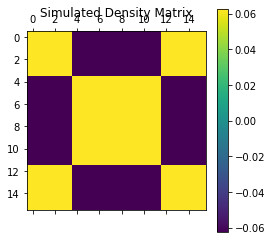

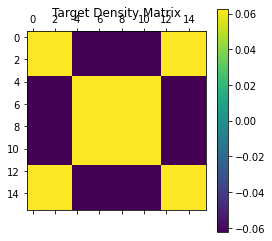

In [230]:
def create_density_plot(data1, sel):

    array = np.array(data1)
    plt.matshow(array)
    plt.colorbar()
    if (sel == 0):
        plt.title("Simulated Density Matrix")
    if (sel == 1):
        plt.title("Target Density Matrix")
    plt.show()

create_density_plot(dm[0].real, 0)
create_density_plot(dm[1].real, 1)